In [198]:
import os
import pandas as pd
import numpy as np
from pycaret.regression import *

In [199]:
INPUT_DIR = os.path.join('..', '..', 'data', 'upsampled')
OUTPUT_DIR_ROOT = '/mnt/d/EMEWS_ML_Pipelines_Output'
MODEL_PATH = 'regression/mean_df/tuned_models/br'
PRE_TRAINED_MODEL_PATH = os.path.join(OUTPUT_DIR_ROOT, MODEL_PATH)
DATAFRAME_NAME = 'mean_df'

## Data Loading and Processing

In [200]:
df = pd.read_csv(os.path.join(INPUT_DIR, f'{DATAFRAME_NAME}.csv'),  parse_dates=['date'])

In [201]:
fh = 60
split_point = df.shape[0] - fh

train_data = df.iloc[:split_point].copy()
test_data = df.iloc[split_point:].copy()

In [202]:
df['total_cat_2'] = df['zone_a__cat_2'] + df['zone_b/c_cat_2']
df['total_cat_3'] = df['zone_a_mwr_cat_3'] + df['zone_a__cat_3'] + df['zone_b/c_cat_3']
df['total_cat_4'] = df['zone_a_mwr_cat_4']

total_patients_all_days =  df['total_cat_2'].sum() + df['total_cat_3'].sum() + df['total_cat_4'].sum()

In [203]:
prob_cat_2 = df['total_cat_2'].sum() / total_patients_all_days
prob_cat_3 = df['total_cat_3'].sum() / total_patients_all_days
prob_cat_4 = df['total_cat_4'].sum() / total_patients_all_days

In [204]:
setup(
    data=train_data,
    target='total_number_of_patients',
    test_data=test_data,
    fold_strategy='timeseries',
    data_split_shuffle=False,
    fold_shuffle=False,
    session_id=123
    );

,Description,Value
0,Session id,123
1,Target,total_number_of_patients
2,Target type,Regression
3,Original data shape,"(618, 21)"
4,Transformed data shape,"(618, 23)"
5,Transformed train set shape,"(558, 23)"
6,Transformed test set shape,"(60, 23)"
7,Numeric features,19
8,Date features,1
9,Preprocess,True


In [205]:
final_model = load_model(PRE_TRAINED_MODEL_PATH, verbose=False)

In [206]:
predictions = predict_model(final_model, test_data)

In [207]:
forecasted_patients = predictions['prediction_label'].mean()
print(f"Forecasted average total patients: {forecasted_patients:.0f}")

Forecasted average total patients: 58


In [208]:
est_cat_2 = int(round(forecasted_patients * prob_cat_2, 0))
est_cat_3 = int(round(forecasted_patients * prob_cat_3, 0))
est_cat_4 = int(round(forecasted_patients * prob_cat_4, 0))

In [209]:
TIME_PER_OBSERVATION_MINS = 8
obs_per_hour = {
        # Triage 2 (10 min intervals) = 6 observations per hour
        'cat_2': 6, 
        # Triage 3 (1 hour intervals) = 1 observation per hour
        'cat_3': 1,
        # Triage 4 (2 hour intervals) = 0.5 observations per hour
        'cat_4': 0.5 
    }

In [210]:
time_for_cat_2 = est_cat_2 * obs_per_hour['cat_2'] * TIME_PER_OBSERVATION_MINS
time_for_cat_3 = est_cat_3 * obs_per_hour['cat_3'] * TIME_PER_OBSERVATION_MINS
time_for_cat_4 = est_cat_4 * obs_per_hour['cat_4'] * TIME_PER_OBSERVATION_MINS

hours_12h_cat_2 = (time_for_cat_2 / 60)
hours_12h_cat_3 = (time_for_cat_3 / 60)
hours_12h_cat_4 = (time_for_cat_4 / 60)

total_hours_12h_shift = hours_12h_cat_2 + hours_12h_cat_3 + hours_12h_cat_4

In [211]:
# Assuming 1 nurse provides 12 hours of work in a 12h shift
nurses_cat_2 = hours_12h_cat_2 / 12
nurses_cat_3 = hours_12h_cat_3 / 12
nurses_cat_4 = hours_12h_cat_4 / 12
total_nurses = total_hours_12h_shift / 12

In [212]:
print("\n" + "="*50)
print("Nurse Needs Forecast for a 12-Hour Shift")
print("="*50)
print(f"Based on a forecast of {forecasted_patients:.0f} total patients:")
print("\n--- CATEGORY 2 ---")
print(f"  - Estimated Patients: {est_cat_2}")
print(f"  - Total Monitoring Hours Needed: {hours_12h_cat_2:.1f} hours")
print(f"  - Number of Nurses Needed: {nurses_cat_2:.2f}")

print("\n--- CATEGORY 3 ---")
print(f"  - Estimated Patients: {est_cat_3}")
print(f"  - Total Monitoring Hours Needed: {hours_12h_cat_3:.1f} hours")
print(f"  - Number of Nurses Needed: {nurses_cat_3:.2f}")

print("\n--- CATEGORY 4 ---")
print(f"  - Estimated Patients: {est_cat_4}")
print(f"  - Total Monitoring Hours Needed: {hours_12h_cat_4:.1f} hours")
print(f"  - Number of Nurses Needed: {nurses_cat_4:.2f}")

print("\n" + "-"*50)
print("--- TOTALS ---")
print(f"  - Total Monitoring Hours Needed: {total_hours_12h_shift:.1f} hours")
print(f"  - TOTAL NURSES NEEDED FOR SHIFT: {total_nurses:.2f}")
print("="*50)


Nurse Needs Forecast for a 12-Hour Shift
Based on a forecast of 58 total patients:

--- CATEGORY 2 ---
  - Estimated Patients: 21
  - Total Monitoring Hours Needed: 16.8 hours
  - Number of Nurses Needed: 1.40

--- CATEGORY 3 ---
  - Estimated Patients: 35
  - Total Monitoring Hours Needed: 4.7 hours
  - Number of Nurses Needed: 0.39

--- CATEGORY 4 ---
  - Estimated Patients: 1
  - Total Monitoring Hours Needed: 0.1 hours
  - Number of Nurses Needed: 0.01

--------------------------------------------------
--- TOTALS ---
  - Total Monitoring Hours Needed: 21.5 hours
  - TOTAL NURSES NEEDED FOR SHIFT: 1.79


In [213]:
AVERAGE_LENGTH_OF_STAY_HOURS = 6
SHIFT_LENGTH_HOURS = 12
TIME_PER_OBSERVATION_MINS = 8

In [214]:
def get_season(date):
    """Maps a date to a Northern Hemisphere season."""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Autumn'

In [215]:
def calculate_shift_needs_detailed(avg_patient_flow):
    """
    Converts patient flow to census, then calculates detailed nursing needs.
    """
    # Step 1: Convert patient flow to average census
    patient_hours = avg_patient_flow * AVERAGE_LENGTH_OF_STAY_HOURS
    avg_census = patient_hours / SHIFT_LENGTH_HOURS
    
    # Step 2: Calculate nurse needs based on the average census
    est_cat_2 = avg_census * prob_cat_2
    est_cat_3 = avg_census * prob_cat_3
    est_cat_4 = avg_census * prob_cat_4

    nurses_cat_2 = (est_cat_2 * obs_per_hour['cat_2'] * TIME_PER_OBSERVATION_MINS) / 60
    nurses_cat_3 = (est_cat_3 * obs_per_hour['cat_3'] * TIME_PER_OBSERVATION_MINS) / 60
    nurses_cat_4 = (est_cat_4 * obs_per_hour['cat_4'] * TIME_PER_OBSERVATION_MINS) / 60
    
    total_nurses = nurses_cat_2 + nurses_cat_3 + nurses_cat_4

    return {
        'avg_flow': avg_patient_flow,
        'avg_census': avg_census,
        'est_cat_2': int(round(est_cat_2, 0)),
        'est_cat_3': int(round(est_cat_3, 0)),
        'est_cat_4': int(round(est_cat_4, 0)),
        'nurses_cat_2': nurses_cat_2,
        'nurses_cat_3': nurses_cat_3,
        'nurses_cat_4': nurses_cat_4,
        'total_nurses': total_nurses
    }

In [216]:
def calculate_nurses_for_shift(daily_predicted_patients):
    return calculate_shift_needs_detailed(daily_predicted_patients)['total_nurses']

In [217]:
temp_df = df.copy()
temp_df['season'] = temp_df['date'].apply(get_season)

In [218]:
predictions = predict_model(final_model, df.drop(columns=['total_number_of_patients']))

In [219]:
temp_df['prediction_label'] = round(predictions['prediction_label'])

In [220]:
seasonal_avg_flow = temp_df.groupby('season')['prediction_label'].mean()

In [221]:
seasonal_avg_flow

season
Autumn    54.794118
Spring    39.679348
Summer    32.570652
Winter    52.421053
Name: prediction_label, dtype: float64

In [222]:
print("="*65)
print("Detailed Seasonal Staffing Report (ALOS = 6 Hours)")
print("="*65)
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
for season in season_order:
    avg_flow = seasonal_avg_flow.get(season, 0)
    if avg_flow > 0:
        results = calculate_shift_needs_detailed(avg_flow)
        print(f"\n--- {season.upper()} ---")
        print(f"  Forecasted Avg. Patient Flow per Shift: {results['avg_flow']}")
        print(f"  Resulting Avg. Patient Census at any time: {results['avg_census']}")
        print("  " + "-"*35)
        print(f"  Nurses for Cat 2: {results['nurses_cat_2']}")
        print(f"  Nurses for Cat 3: {results['nurses_cat_3']}")
        print(f"  Nurses for Cat 4: {results['nurses_cat_4']}")
        print("  " + "-"*35)
        print(f"  TOTAL AVG. NURSES NEEDED PER SHIFT: {results['total_nurses']}")
print("\n" + "="*65)

Detailed Seasonal Staffing Report (ALOS = 6 Hours)

--- SPRING ---
  Forecasted Avg. Patient Flow per Shift: 39.67934782608695
  Resulting Avg. Patient Census at any time: 19.839673913043477
  -----------------------------------
  Nurses for Cat 2: 5.893143404320218
  Nurses for Cat 3: 1.5993191539748086
  Nurses for Cat 4: 0.03189006685547595
  -----------------------------------
  TOTAL AVG. NURSES NEEDED PER SHIFT: 7.524352625150502

--- SUMMER ---
  Forecasted Avg. Patient Flow per Shift: 32.57065217391305
  Resulting Avg. Patient Census at any time: 16.285326086956523
  -----------------------------------
  Nurses for Cat 2: 4.837365898108626
  Nurses for Cat 3: 1.3127954649734324
  Nurses for Cat 4: 0.026176848467999916
  -----------------------------------
  TOTAL AVG. NURSES NEEDED PER SHIFT: 6.176338211550059

--- AUTUMN ---
  Forecasted Avg. Patient Flow per Shift: 54.794117647058826
  Resulting Avg. Patient Census at any time: 27.39705882352941
  ----------------------------

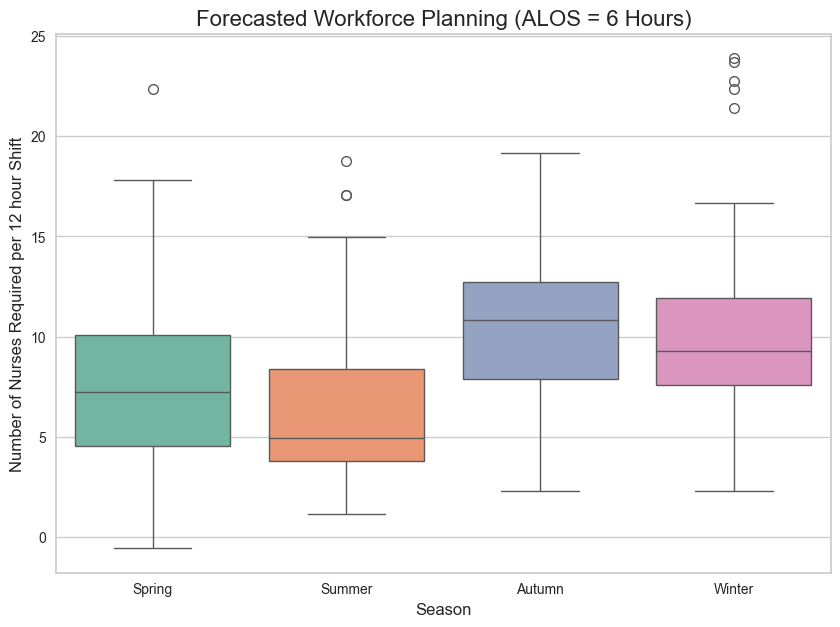

In [230]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_df['nurses_needed'] = temp_df['prediction_label'].apply(calculate_nurses_for_shift)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))
sns.boxplot(x='season', y='nurses_needed', data=temp_df, order=season_order, palette="Set2")
plt.title(f'Forecasted Workforce Planning (ALOS = {AVERAGE_LENGTH_OF_STAY_HOURS} Hours)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Nurses Required per 12 hour Shift', fontsize=12)
# plt.show()
plt.savefig('forcast.png', dpi=300, bbox_inches='tight')

In [224]:
temp_df['season'] = temp_df['date'].apply(get_season)

# Group by season and calculate the average patient count for each
seasonal_avg_patients = temp_df.groupby('season')['total_number_of_patients'].mean()

print("--- Average Patients Per Day by Season ---")
print(seasonal_avg_patients.round(1))
print("-" * 42 + "\n")

--- Average Patients Per Day by Season ---
season
Autumn    55.6
Spring    40.0
Summer    31.6
Winter    52.4
Name: total_number_of_patients, dtype: float64
------------------------------------------



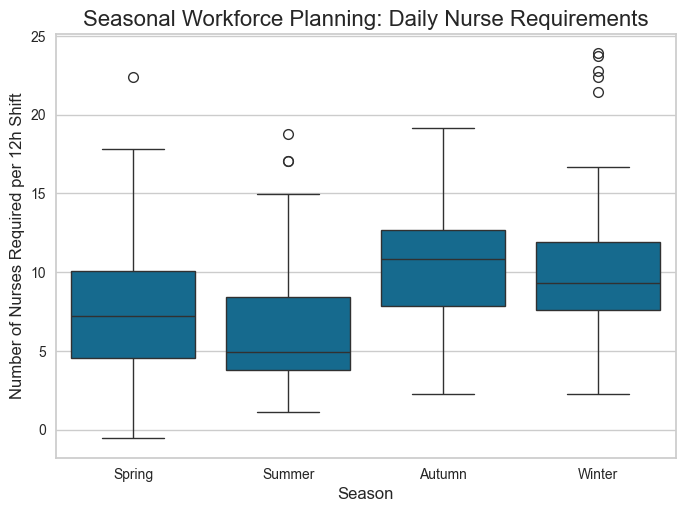

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='season', y='nurses_needed', data=temp_df, order=season_order)

# Add title and labels for clarity
plt.title('Seasonal Workforce Planning: Daily Nurse Requirements', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Nurses Required per 12h Shift', fontsize=12)

# Display the plot
plt.show()